In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
sns.set(font_scale=2, style='white')
%matplotlib inline

# Load and parameterize data

In [2]:
# Log data for user activity
path_usage = '../data/processed/fall-2018/user-activity.jsonl'
datahub = pd.read_json(path_usage, lines=True)

In [3]:
# Cost per dat
cost = pd.read_json('../data/processed/fall-2018/cloud-costs.jsonl', lines=True).squeeze()

# Re-cast as a DataFrame because the data isn't being read properly for some reason
cost = pd.DataFrame.from_records(cost.values)

# Munging

## Convert to daily amounts

In [4]:
# Unique daily users
daily_usage = datahub.set_index('timestamp')['user']
daily_usage = daily_usage.resample('D').nunique()

In [5]:
# Daily cost
cost = cost.rename(columns={'startTime': 'time'}).set_index('time')['cost']
cost.index = pd.to_datetime(cost.index)
daily_cost = cost.resample('D').sum()

In [6]:
# Combine into a single dataframe based on day
total = pd.merge(daily_usage.to_frame(), daily_cost.to_frame('cost'), left_index=True, right_index=True)
total.index.name = 'date'

# New features

In [7]:
total['cost_per_user'] = total['cost'] / total['user']

# Clean and subset data

In [8]:
# This is the data we'll modify and plot
total_viz = total.copy()

In [9]:
# Remove some dates where we know weird stuff was happening
remove_start = '2018-10-12'
remove_stop = '2018-10-16'
total_viz[total_viz.eval('date > @remove_start and date < @remove_stop')] = np.nan

In [10]:
# Only keep a subset of dates in general
start_date = "2018-07-30"
stop_date = "2018-12-15"
total_viz = total_viz.query("date > @start_date and date < @stop_date")

# Viz

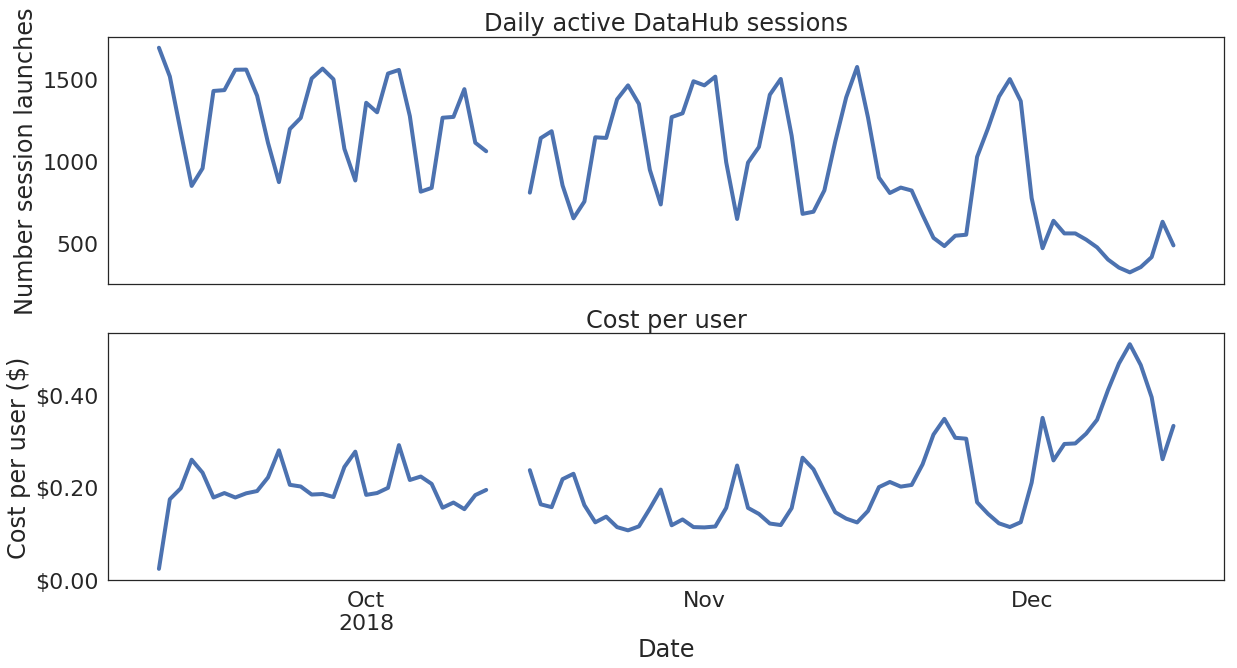

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

ax = axs[0]
total_viz['user'].plot(lw=4, ax=ax)
ax.set(title='Daily active DataHub sessions', xlabel='Date', ylabel='Number session launches')

ax = axs[1]
total_viz['cost_per_user'].plot(lw=4, ax=ax)
ax.set(title='Cost per user', xlabel='Date', ylabel='Cost per user ($)')
ax.yaxis.set_major_formatter(FormatStrFormatter('$%.2f'))

[Text(0, 0.5, 'daily cost per user'),
 Text(0.5, 0, 'n daily users'),
 Text(0.5, 1.0, 'cost per user vs. total daily usage')]

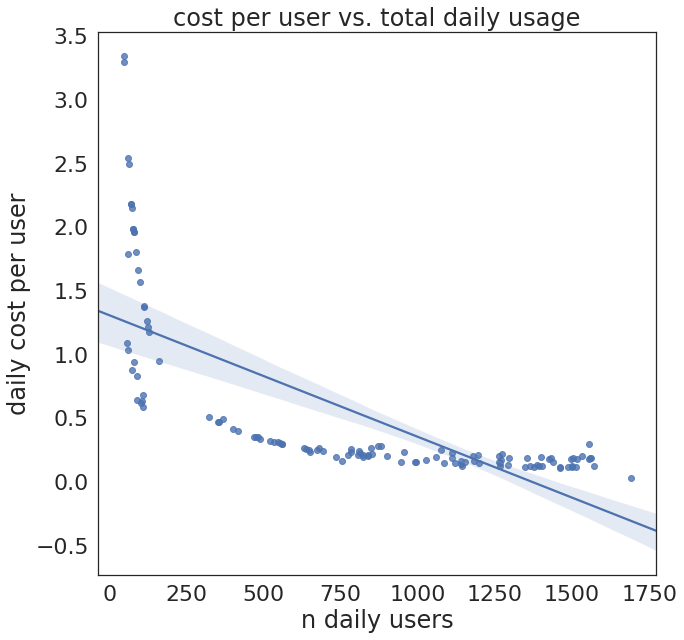

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.regplot('user', 'cost_per_user', data=total)
ax.set(xlabel='n daily users', ylabel='daily cost per user', title="cost per user vs. total daily usage")

# Stats

In [13]:
# Semester cost per user
semester_cost_per_user = total['cost_per_user'].resample('W').sum().mean() * 18
semester_cost_per_user

64.6588008144806

In [14]:
# Annual cost per use
total['cost_per_user'].resample('M').sum().mean() * 12

163.8022953966842